# Data Loading and Preprocessing Functions

In [1]:
import warnings
warnings.filterwarnings('ignore')
from time import time
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Cleaning and loading

In [2]:
def cleaned(text):
  """
  function for cleaning text and tokenizing
  parameters: text (str)
  return: cleaned text (str)
  """
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = text.lower().strip()
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word not in stop_words]
  stemmer = SnowballStemmer('english')
  filtered_words = [stemmer.stem(word) for word in filtered_words]
  return ' '.join(filtered_words)

In [3]:
def load_preprocess(train_path, test_path, solution_path):
  """
  function for loading and preprocessing data
  parameters: train_path (str), test_path (str), solution_path (str)
  return: train (pd.DataFrame), test (pd.DataFrame), solution (pd.DataFrame)
  """
  try:
    start = time()
    train = pd.read_csv(train_path, delimiter=":::", engine="python", names = ['id', 'title', 'genre', 'description'])
    print("\n\nInitially (train data):\n")
    print(train.info())
    train['description'] = train['description'].apply(cleaned)
    train = train.drop('id', axis=1)
    train = train.drop_duplicates()
    train = train.dropna()
    train = train.reset_index(drop=True)
    print("\n\nAfter cleaning (train data):\n")
    print(train.info())

    test = pd.read_csv(test_path, delimiter=":::", engine="python", names = ['id', 'title', 'description'])
    print("\n\nInitially (test data):\n")
    print(test.info())
    test['description'] = test['description'].apply(cleaned)
    test = test.drop('id', axis=1)
    test = test.drop_duplicates()
    test = test.dropna()
    test = test.reset_index(drop=True)
    print("\n\nAfter cleaning (test data):\n")
    print(test.info())

    solution = pd.read_csv(solution_path, delimiter=":::", engine="python", names = ['id', 'title', 'genre', 'description'])
    print("\n\nInitially (solution data):\n")
    print(solution.info())
    solution = solution.drop_duplicates()
    solution = solution.dropna()
    solution = solution.reset_index(drop=True)
    solution = solution.drop('id', axis=1)
    solution = solution.drop('title', axis=1)
    solution = solution.drop('description', axis=1)
    print("\n\nAfter cleaning (solution data):\n")
    print(solution.info())
    
    end = time()
    print(f"\n\n Execution time: {end - start}\n")

    return train, test, solution
  except FileNotFoundError:
    print("The file was not found")
    return None, None, None
  except Exception as e:
    print(e)
    return None, None, None

## Encoding

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
def encoder(train, test, solution):
  """
  function for encoding data
  parameters: train (pd.DataFrame), test (pd.DataFrame), solution (pd.DataFrame)
  return: train (pd.DataFrame), test (pd.DataFrame), solution (pd.DataFrame)
  """
  try:
    le = LabelEncoder()
    train['genre'] = le.fit_transform(train['genre'])
    solution['genre'] = le.transform(solution['genre'])
    print("Encoded Labels:")
    for label, value in zip(le.classes_, le.transform(le.classes_)):
        print(f"{label} : {value}")
    return train, test, solution
  except Exception as e:
    print(e)
    return None

## Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
def vectorizer(train, test):
  """
  function for vectorizing data
  parameters: train (pd.DataFrame), test (pd.DataFrame)
  return: train_tfidf (scipy.sparse.csr_matrix), test_tfidf (scipy.sparse.csr_matrix)
  """
  tfidf = TfidfVectorizer(max_features=5000)
  train_tfidf = tfidf.fit_transform(train['description'])
  test_tfidf = tfidf.transform(test['description'])
  return train_tfidf, test_tfidf

# Train-test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def train_and_test_split(train, size):
  """
  function for splitting data into train and test sets
  parameters: train (pd.DataFrame), size (float)
  return: X_train (pd.DataFrame), X_test (pd.DataFrame), y_train (pd.Series), y_test (pd.Series)
  """
  X = train['description']
  y = train['genre']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
  train_df = pd.DataFrame({'description': X_train, 'genre': y_train})
  test_df = pd.DataFrame({'description': X_test, 'genre': y_test})
  return train_df, test_df

# Visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def visualizer(df):
  """
  function for visualizing data
  parameters: df (pd.DataFrame)
  return: None
  """
  plt.figure(figsize=(10, 6))
  sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index, orient='h')

  for idx, value in enumerate(df['genre'].value_counts()):
      plt.text(value, idx, str(value))

  plt.title('Genre Distribution')
  plt.xlabel('Count')
  plt.ylabel('Genre')
  plt.show()

# Sampling

In [12]:
import numpy as np
from sklearn.utils import resample

In [13]:
def custom_sampler(df, threshold=1000):
    """
    Function for balancing data
    Parameters:
        mat (scipy.sparse.csr_matrix): The feature matrix.
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (int): The threshold for sampling. Defaults to 1000.
    Returns:
        df_resampled (pd.DataFrame): The resampled DataFrame.
    """
    class_counts = df['genre'].value_counts()

    resampled_indices = []

    for class_label, count in class_counts.items():
        class_indices = np.where(df['genre'] == class_label)[0]
        if count > threshold:
            resampled_indices.append(resample(class_indices, n_samples=threshold, random_state=42))
        else:
            resampled_indices.append(resample(class_indices, n_samples=threshold, replace=True, random_state=42))

    final_indices = np.concatenate(resampled_indices)

    df_resampled = df.iloc[final_indices].reset_index(drop=True)

    return df_resampled

# Model Training and Saving

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [15]:
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(class_weight='balanced'),
    "SVC": SVC(class_weight='balanced')
}

In [16]:
import joblib

In [17]:
model_paths1 = {
    'MultinomialNB': './models/mnb_model1.joblib',
    'LogisticRegression': './models/lgr_model1.joblib',
    'SVC': './models/svc_model1.joblib'
}

model_paths2 = {
    'MultinomialNB': './models/mnb_model2.joblib',
    'LogisticRegression': './models/lgr_model2.joblib',
    'SVC': './models/svc_model2.joblib'
}

In [18]:
def train_eval(X_train, y_train, X_test, y_test, models, path):
  """
  function for training, evaluating models and saving models
  parameters: X_train (pd.DataFrame), y_train (pd.Series), X_test (pd.DataFrame), y_test (pd.Series), models (dict), path (str)
  return: None
  """
  for name, model in models.items():
    start = time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    joblib.dump(model, path[name])
    end = time()
    print(f"\n\n Execution time: {end - start}\n")
    print("-" * 50)

# Loading and using saved models

In [19]:
def load_and_predict(model_path, X_new):
    """
    Function to load a saved model and make predictions.
    Parameters:
    - model_path (str): Path to the saved model file.
    - X_new (pd.DataFrame): New data to make predictions on.
    Returns:
    - y_pred (np.ndarray): Predictions made by the loaded model.
    """
    start = time()
    model = joblib.load(model_path)
    y_pred = model.predict(X_new)
    end = time()
    print(f"\n\n Execution time: {end - start}\n")
    
    return y_pred

# Function calls

In [20]:
train_path = "train_data.txt"
test_path = "test_data.txt"
solution_path = "test_data_solution.txt"

In [21]:
train, test, test_solution = load_preprocess(train_path, test_path, solution_path)



Initially (train data):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  int64 
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB
None


After cleaning (train data):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB
None


Initially (test data):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 

In [22]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
learn_df, validate_df = train_and_test_split(train, 0.2)

In [24]:
learn_df, _, validate_df = encoder(learn_df, [], validate_df)

Encoded Labels:
 action  : 0
 adult  : 1
 adventure  : 2
 animation  : 3
 biography  : 4
 comedy  : 5
 crime  : 6
 documentary  : 7
 drama  : 8
 family  : 9
 fantasy  : 10
 game-show  : 11
 history  : 12
 horror  : 13
 music  : 14
 musical  : 15
 mystery  : 16
 news  : 17
 reality-tv  : 18
 romance  : 19
 sci-fi  : 20
 short  : 21
 sport  : 22
 talk-show  : 23
 thriller  : 24
 war  : 25
 western  : 26


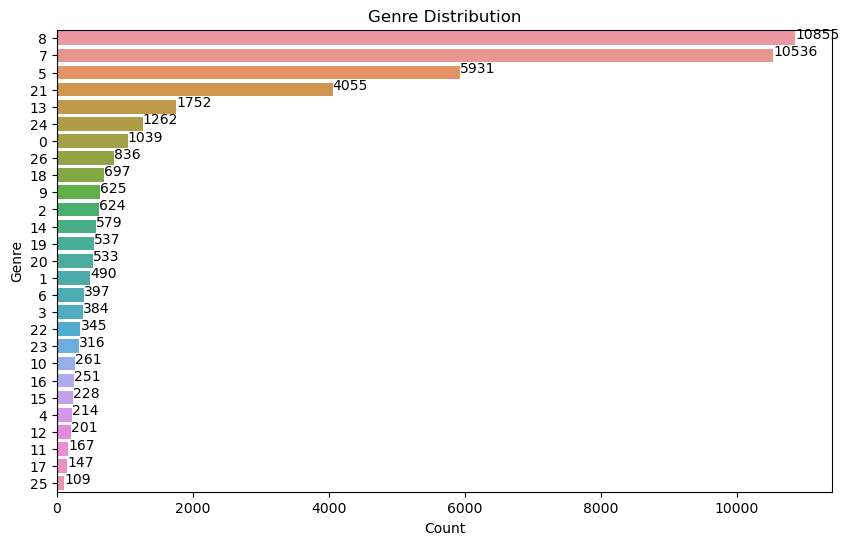

In [25]:
visualizer(learn_df)

In [26]:
df = custom_sampler(learn_df, 1000)

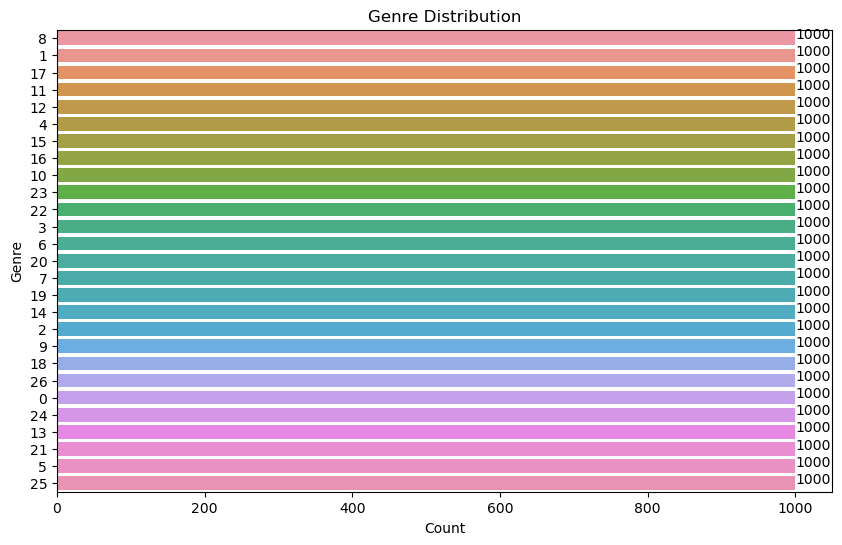

In [27]:
visualizer(df)

In [28]:
learn_tfidf, validate_tfidf = vectorizer(df, validate_df)

In [29]:
train_eval(learn_tfidf, df['genre'], validate_tfidf, validate_df['genre'], models, model_paths1)

Model: MultinomialNB
              precision    recall  f1-score   support

           0       0.38      0.39      0.38       276
           1       0.29      0.63      0.40       100
           2       0.21      0.21      0.21       151
           3       0.22      0.26      0.24       114
           4       0.03      0.18      0.06        51
           5       0.60      0.27      0.37      1516
           6       0.11      0.37      0.17       108
           7       0.79      0.41      0.54      2560
           8       0.63      0.34      0.44      2758
           9       0.12      0.23      0.16       159
          10       0.11      0.32      0.16        62
          11       0.32      0.78      0.46        27
          12       0.03      0.24      0.06        42
          13       0.51      0.68      0.58       452
          14       0.31      0.84      0.45       152
          15       0.08      0.27      0.12        49
          16       0.08      0.19      0.11        68
      

SVC takes significant time in training, hence sampling all classes to 8000 for the final models for the entire training data file

In [30]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

In [31]:
train_, test_, solution_ = encoder(train, test, test_solution)

Encoded Labels:
 action  : 0
 adult  : 1
 adventure  : 2
 animation  : 3
 biography  : 4
 comedy  : 5
 crime  : 6
 documentary  : 7
 drama  : 8
 family  : 9
 fantasy  : 10
 game-show  : 11
 history  : 12
 horror  : 13
 music  : 14
 musical  : 15
 mystery  : 16
 news  : 17
 reality-tv  : 18
 romance  : 19
 sci-fi  : 20
 short  : 21
 sport  : 22
 talk-show  : 23
 thriller  : 24
 war  : 25
 western  : 26


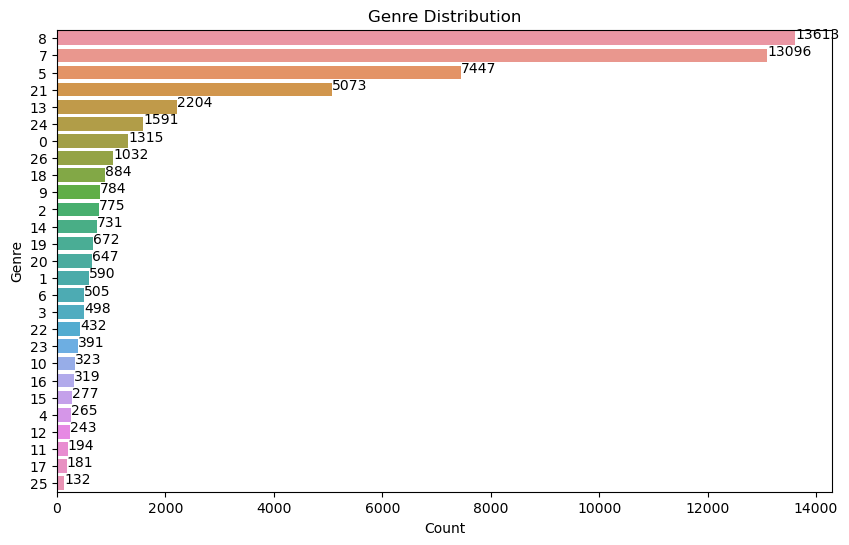

In [32]:
visualizer(train_)

In [33]:
df2 = custom_sampler(train_, 8000)

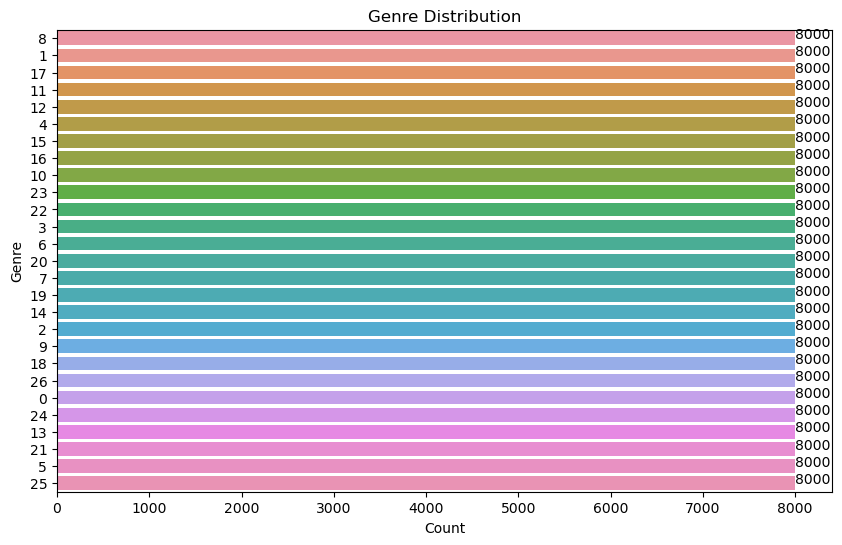

In [34]:
visualizer(df2)

In [35]:
train_tfidf2, test_tfidf2 = vectorizer(df2, test_)

Training and saving final models

In [36]:
for name, model in models.items():
    start = time()
    model.fit(train_tfidf2, df2['genre'])
    print(f"Model: {name}")
    joblib.dump(model, model_paths2[name])
    end = time()
    print(f"\n\n Execution time: {end - start}\n")
    print("-" * 50)

Model: MultinomialNB


 Execution time: 0.1477656364440918

--------------------------------------------------
Model: LogisticRegression


 Execution time: 34.346805572509766

--------------------------------------------------
Model: SVC


 Execution time: 4010.784491300583

--------------------------------------------------


Loading the final trained models

###### SVC

In [37]:
path = './models/svc_model2.joblib'
prediction = load_and_predict(path, test_tfidf2)



 Execution time: 1508.3273577690125



In [41]:
print(classification_report(solution_['genre'], prediction))

              precision    recall  f1-score   support

           0       0.39      0.45      0.42      1314
           1       0.57      0.43      0.49       590
           2       0.48      0.28      0.35       775
           3       0.39      0.15      0.21       498
           4       0.00      0.00      0.00       264
           5       0.51      0.63      0.56      7446
           6       0.24      0.10      0.14       505
           7       0.72      0.77      0.75     13096
           8       0.61      0.63      0.62     13612
           9       0.38      0.17      0.23       783
          10       0.36      0.11      0.17       322
          11       0.85      0.59      0.70       193
          12       0.38      0.01      0.02       243
          13       0.61      0.65      0.63      2204
          14       0.53      0.62      0.57       731
          15       0.31      0.07      0.12       276
          16       0.27      0.03      0.06       318
          17       0.53    

###### Multinomial NB

In [42]:
path2 = './models/mnb_model2.joblib'
prediction2 = load_and_predict(path2, test_tfidf2)



 Execution time: 0.044303178787231445



In [43]:
print(classification_report(solution_['genre'], prediction2))

              precision    recall  f1-score   support

           0       0.35      0.46      0.40      1314
           1       0.37      0.61      0.46       590
           2       0.20      0.23      0.21       775
           3       0.18      0.27      0.22       498
           4       0.04      0.16      0.07       264
           5       0.59      0.41      0.48      7446
           6       0.12      0.31      0.17       505
           7       0.76      0.53      0.62     13096
           8       0.68      0.41      0.51     13612
           9       0.18      0.26      0.21       783
          10       0.12      0.28      0.17       322
          11       0.64      0.69      0.67       193
          12       0.06      0.24      0.10       243
          13       0.54      0.66      0.59      2204
          14       0.30      0.75      0.42       731
          15       0.10      0.18      0.13       276
          16       0.08      0.14      0.10       318
          17       0.14    

###### Logistic Regression

In [44]:
path3 = './models/lgr_model2.joblib'
prediction3 = load_and_predict(path3, test_tfidf2)



 Execution time: 0.04548358917236328



In [45]:
print(classification_report(solution_['genre'], prediction3))

              precision    recall  f1-score   support

           0       0.32      0.48      0.38      1314
           1       0.36      0.60      0.45       590
           2       0.20      0.35      0.25       775
           3       0.15      0.28      0.20       498
           4       0.04      0.12      0.06       264
           5       0.58      0.45      0.51      7446
           6       0.12      0.28      0.17       505
           7       0.80      0.56      0.66     13096
           8       0.70      0.39      0.50     13612
           9       0.14      0.30      0.19       783
          10       0.11      0.24      0.15       322
          11       0.65      0.68      0.66       193
          12       0.07      0.22      0.11       243
          13       0.56      0.63      0.59      2204
          14       0.39      0.68      0.50       731
          15       0.12      0.27      0.17       276
          16       0.07      0.14      0.10       318
          17       0.15    

##### Finally, it can be seen that, overall, SVC gives better results compared to the rest

### Custom Test

In [47]:
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(df2['description'])
joblib.dump(vectorizer, './models/vectorizer.joblib')

['./models/vectorizer.joblib']

In [48]:
vec = joblib.load('./models/vectorizer.joblib')

In [74]:
ctest = '''In a small seaside town, Clara, an artist, and Alex, who owns a cozy bookshop, meet unexpectedly. 
As they face their own challenges, they find a strong connection that grows with every sunset and heartfelt talk. 
Set against the beautiful ocean backdrop, "Whispers of Love " tells a story of lasting strength of love and the 
joy of finding your true partner when you least expect it.
'''
ctest = cleaned(ctest)

In [75]:
ctest = pd.Series([ctest])

In [76]:
ctest = vec.transform(ctest)

In [77]:
encoded_labels = {
    0: "action",
    1: "adult",
    2: "adventure",
    3: "animation",
    4: "biography",
    5: "comedy",
    6: "crime",
    7: "documentary",
    8: "drama",
    9: "family",
    10: "fantasy",
    11: "game-show",
    12: "history",
    13: "horror",
    14: "music",
    15: "musical",
    16: "mystery",
    17: "news",
    18: "reality-tv",
    19: "romance",
    20: "sci-fi",
    21: "short",
    22: "sport",
    23: "talk-show",
    24: "thriller",
    25: "war",
    26: "western"
}

In [78]:
def get_genre(encoded_value):
    return encoded_labels.get(encoded_value, "Genre")
def prediction(model_path, test):
    model = joblib.load(model_path)
    res = model.predict(test)
    genre = get_genre(res[0])
    return genre

In [79]:
result = prediction('./models/svc_model2.joblib', ctest)

In [80]:
print(result)

romance


In [86]:
ctest = '''In a world where danger prowls in every corner,
relentless agent Jake Hunter must race against the clock to crush a merciless terrorist plot. 
With bone-crushing stunts, high-speed pursuits, and explosive clashes,
"Shadow Fury" is an unrelenting adrenaline rush that grips you from the first shot to the final blow. 
Follow Jake as he battles savage adversaries and unravels a web of deceit that threatens to obliterate everything he holds dear.
Brutal, "Shadow Fury" delivers relentless intensity and raw, gut-wrenching suspense in every frame.
'''

In [87]:
ctest = cleaned(ctest)

In [88]:
ctest = pd.Series([ctest])

In [89]:
ctest = vec.transform(ctest)

In [90]:
result = prediction('./models/svc_model2.joblib', ctest)
print(result)

action
